<a href="https://colab.research.google.com/github/jmohsbeck1/jpmc_mle/blob/week-Apr.-17/Tuning_Hyperparms_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Tune the LR
import os
import numpy as np
import pandas as pd
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')
df = pd.read_csv("https://raw.githubusercontent.com/fenago/datasets/main/winequalityN.csv")
df.sample(5)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2315,white,7.7,0.42,0.38,8.1,0.061,49.0,144.0,0.99660,3.40,0.58,11.0,6
6349,red,7.8,0.32,0.44,2.7,0.104,8.0,17.0,0.99732,3.33,0.78,11.0,7
1726,white,7.0,0.30,0.32,6.4,0.034,28.0,97.0,0.99240,3.23,0.44,11.8,6
2791,white,6.6,0.25,0.51,8.0,0.047,61.0,189.0,0.99604,3.22,0.49,9.2,5
975,white,7.6,0.30,0.25,4.3,0.054,22.0,111.0,0.99560,3.12,0.49,9.2,5


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Prepare the data
df = df.dropna()
df['is_white_wine'] = [
    1 if type == 'white' else 0 for typ in df['type']
]
df['is_good_wine'] = [
    1 if quality >= 6 else 0 for quality in df['quality']
]
df.drop(['type', 'quality'], axis=1, inplace=True)

# Train/test split
X = df.drop('is_good_wine', axis=1)
y = df['is_good_wine']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, random_state=42
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# How to optimize the learning rate in tensorflow
import tensorflow as tf
tf.random.set_seed(42)

In [ ]:
1e-3 * 10 ** (1 / 30), 1e-3 * 10 ** (100 / 30)


(0.0010797751623277097, 2.1544346900318847)

In [ ]:
initial_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

initial_model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy')
    ]
)

initial_history = initial_model.fit(
    X_train_scaled,
    y_train,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-3 * 10 ** (epoch / 30)
        )
    ]
)

Epoch 1/100
162/162 [==============================] - 2s 6ms/step - loss: 0.5259 - accuracy: 0.7352 - lr: 0.0010
Epoch 2/100
162/162 [==============================] - 1s 6ms/step - loss: 0.4955 - accuracy: 0.7613 - lr: 0.0011
Epoch 3/100
162/162 [==============================] - 1s 4ms/step - loss: 0.4818 - accuracy: 0.7710 - lr: 0.0012
Epoch 4/100
162/162 [==============================] - 1s 4ms/step - loss: 0.4668 - accuracy: 0.7810 - lr: 0.0013
Epoch 5/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4570 - accuracy: 0.7851 - lr: 0.0014
Epoch 6/100
162/162 [==============================] - 1s 4ms/step - loss: 0.4509 - accuracy: 0.7890 - lr: 0.0015
Epoch 7/100
162/162 [==============================] - 1s 4ms/step - loss: 0.4438 - accuracy: 0.7928 - lr: 0.0016
Epoch 8/100
162/162 [==============================] - 1s 3ms/step - loss: 0.4364 - accuracy: 0.7957 - lr: 0.0017
Epoch 9/100
162/162 [==============================] - 1s 4ms/step - loss: 0.4292 - accu

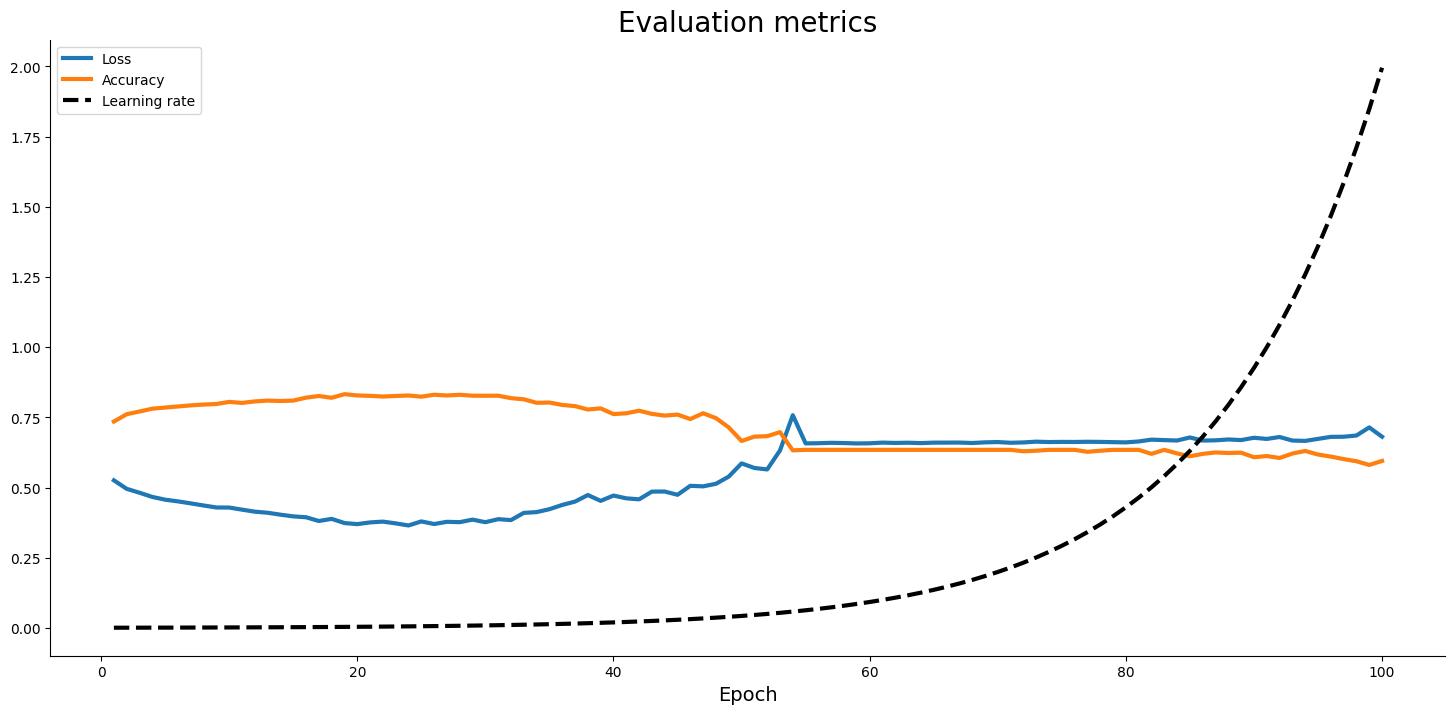

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False 

plt.plot(
    np.arange(1, 101), 
    initial_history.history['loss'], 
    label='Loss', lw=3
)
plt.plot(
    np.arange(1, 101), 
    initial_history.history['accuracy'], 
    label='Accuracy', lw=3
)
plt.plot(
    np.arange(1, 101), 
    initial_history.history['lr'], 
    label='Learning rate', color='#000', lw=3, linestyle='--'
)
plt.title('Evaluation metrics', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

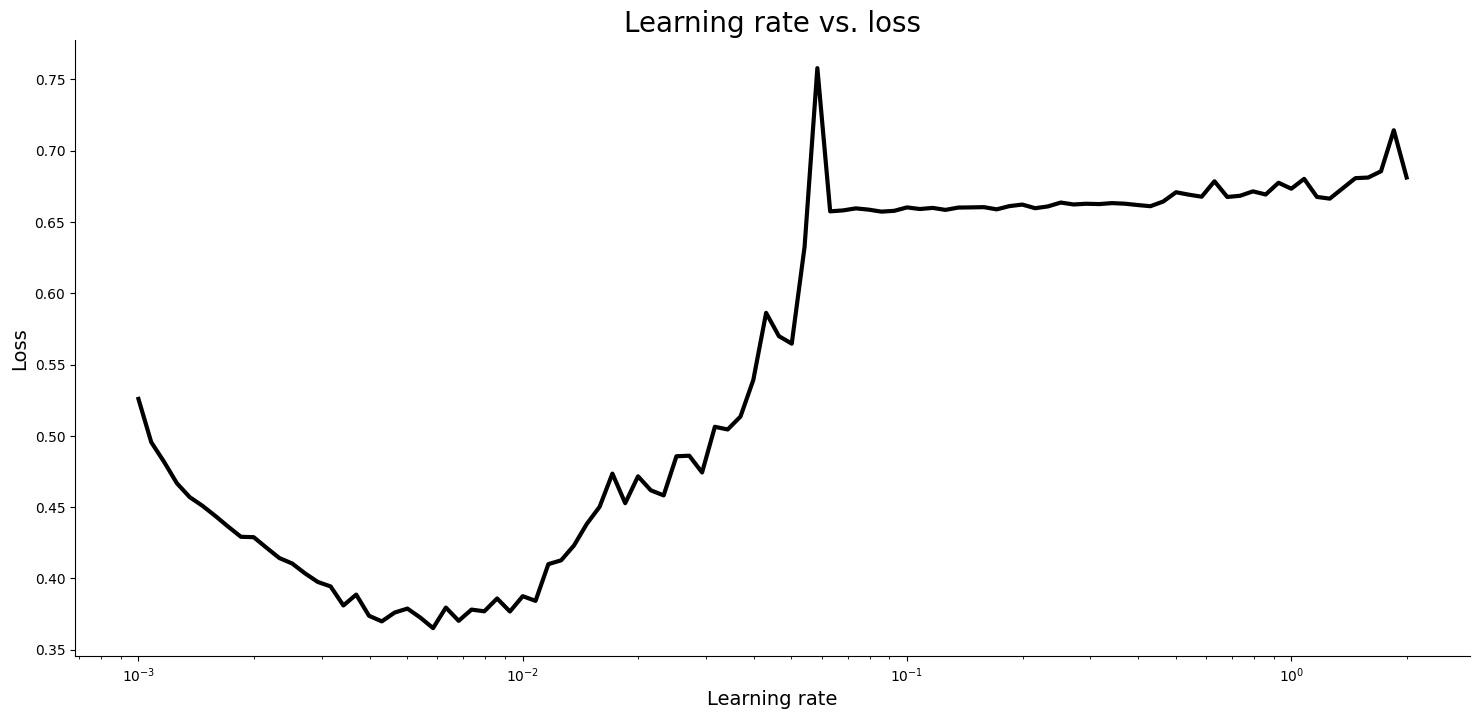

In [ ]:
learning_rates = 1e-3 * (10 ** (np.arange(100) / 30))
plt.semilogx(
    learning_rates, 
    initial_history.history['loss'], 
    lw=3, color='#000'
)
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14);

In [ ]:
model_optimized = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_optimized.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.007),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy')
    ]
)

history_optimized = model_optimized.fit(
    X_train_scaled,
    y_train,
    epochs=100
)

Epoch 1/100
162/162 [==============================] - 2s 4ms/step - loss: 0.5324 - accuracy: 0.7412
Epoch 2/100
162/162 [==============================] - 1s 7ms/step - loss: 0.5080 - accuracy: 0.7567
Epoch 3/100
162/162 [==============================] - 1s 7ms/step - loss: 0.4991 - accuracy: 0.7565
Epoch 4/100
162/162 [==============================] - 1s 7ms/step - loss: 0.4879 - accuracy: 0.7640
Epoch 5/100
162/162 [==============================] - 1s 9ms/step - loss: 0.4797 - accuracy: 0.7758
Epoch 6/100
162/162 [==============================] - 1s 9ms/step - loss: 0.4707 - accuracy: 0.7847
Epoch 7/100
162/162 [==============================] - 1s 6ms/step - loss: 0.4689 - accuracy: 0.7747
Epoch 8/100
162/162 [==============================] - 1s 6ms/step - loss: 0.4541 - accuracy: 0.7876
Epoch 9/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4437 - accuracy: 0.7952
Epoch 10/100
162/162 [==============================] - 1s 4ms/step - loss: 0.4391 - accura

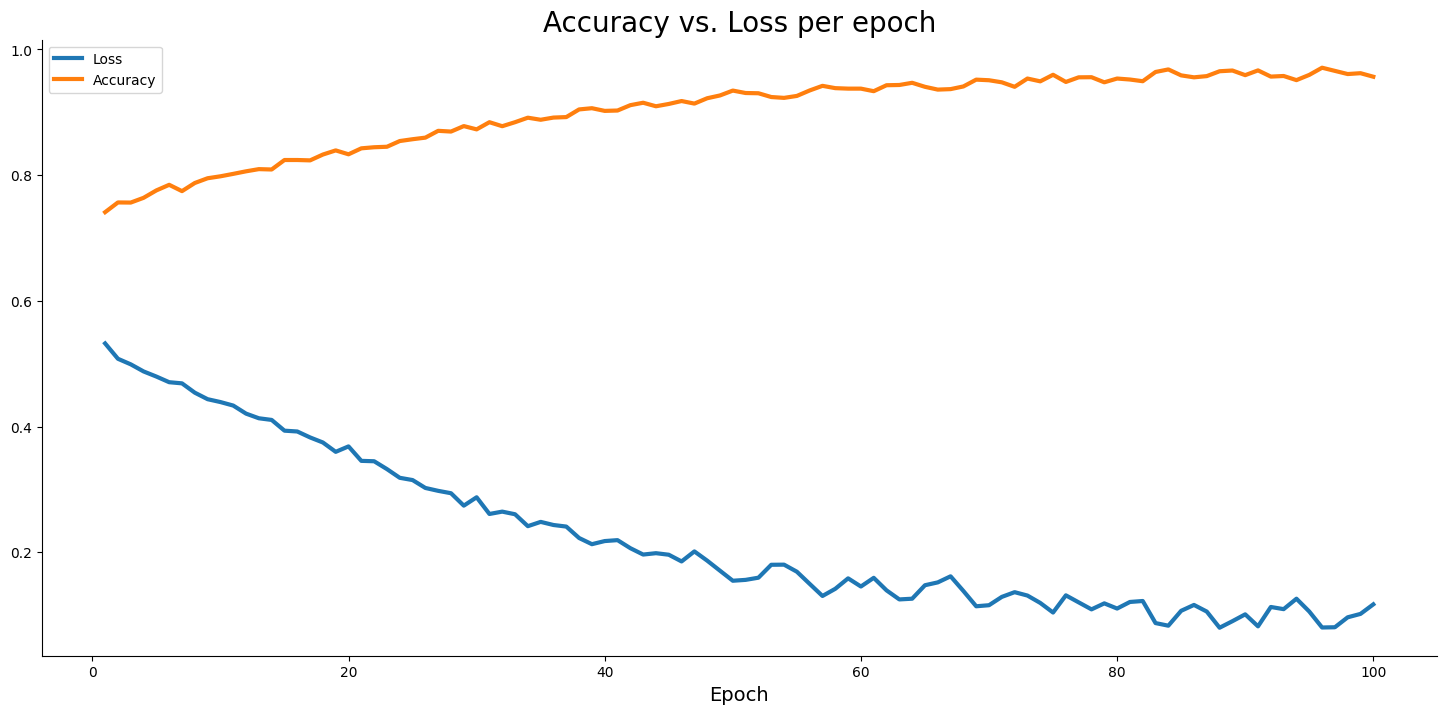

In [ ]:
plt.plot(
    np.arange(1, 101), 
    history_optimized.history['loss'], 
    label='Loss', lw=3
)
plt.plot(
    np.arange(1, 101), 
    history_optimized.history['accuracy'], 
    label='Accuracy', lw=3
)
plt.title('Accuracy vs. Loss per epoch', size=20)
plt.xlabel('Epoch', size=14)
plt.legend()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

predictions = model_optimized.predict(X_test_scaled)
prediction_classes = [1 if prob > 0.5 else 0 for prob in np.ravel(predictions)]


print(f'Accuracy on the test set: {accuracy_score(y_test, prediction_classes):.2f}')
print()
print('Confusion matrix:')
print(confusion_matrix(y_test, prediction_classes))

41/41 [==============================] - 0s 2ms/step
Accuracy on the test set: 0.80

Confusion matrix:
[[338 144]
 [118 693]]


In [ ]:
# How do you find the Optimal NN Architecture
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import itertools
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

tf.random.set_seed(42)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
warnings.filterwarnings('ignore')
df = pd.read_csv("https://raw.githubusercontent.com/fenago/datasets/main/winequalityN.csv")
df.sample(5)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
2486,white,6.7,0.24,0.32,10.3,0.079,37.0,122.0,0.99662,3.02,0.45,8.8,5
2248,white,7.4,0.20,0.29,1.7,0.047,16.0,100.0,0.99243,3.28,0.45,10.6,6
4408,white,5.7,0.29,0.16,7.9,0.044,48.0,197.0,0.99512,3.21,0.36,9.4,5
3283,white,6.6,0.20,0.14,4.4,0.184,35.0,168.0,0.99396,2.93,0.45,9.4,6
3674,white,6.6,0.34,0.20,1.0,0.053,26.0,112.0,0.99336,3.32,0.55,9.1,5


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Prepare the data
df = df.dropna()
df['is_white_wine'] = [1 if typ == 'white' else 0 for typ in df['type']]
df['is_good_wine'] = [1 if quality >= 6 else 0 for quality in df['quality']]
df.drop(['type', 'quality'], axis=1, inplace=True)

# Train/test split
X = df.drop('is_good_wine', axis=1)
y = df['is_good_wine']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, random_state=42
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
num_layers = 3
min_nodes_per_layer = 64
max_nodes_per_layer = 256
node_step_size = 64

In [ ]:
node_options = list(range(
    min_nodes_per_layer, 
    max_nodes_per_layer + 1, 
    node_step_size
))
node_options

[64, 128, 192, 256]

In [ ]:
two_layer_possibilities = [node_options, node_options]

In [ ]:
list(itertools.product(*two_layer_possibilities))

[(64, 64),
 (64, 128),
 (64, 192),
 (64, 256),
 (128, 64),
 (128, 128),
 (128, 192),
 (128, 256),
 (192, 64),
 (192, 128),
 (192, 192),
 (192, 256),
 (256, 64),
 (256, 128),
 (256, 192),
 (256, 256)]

In [ ]:
layer_possibilities = [node_options] * num_layers
layer_node_permutations = list(itertools.product(*layer_possibilities))

In [ ]:
layer_node_permutations

In [ ]:
for permutation in layer_node_permutations[:2]:
    for nodes_at_layer in permutation:
        print(nodes_at_layer)
    print()

64
64
64

64
64
128



In [ ]:
models = []

for permutation in layer_node_permutations:
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(12,)))
    model_name = ''
    
    for nodes_at_layer in permutation:
        model.add(tf.keras.layers.Dense(nodes_at_layer, activation='relu'))
        model_name += f'dense{nodes_at_layer}_'
        
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model._name = model_name[:-1]
    
    models.append(model)

In [ ]:
models[0].summary()

Model: "dense64_dense64_dense64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                832       
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,217
Trainable params: 9,217
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def get_models(num_layers: int,
               min_nodes_per_layer: int,
               max_nodes_per_layer: int,
               node_step_size: int,
               input_shape: tuple,
               hidden_layer_activation: str = 'relu',
               num_nodes_at_output: int = 1,
               output_layer_activation: str = 'sigmoid') -> list:
    
    node_options = list(range(min_nodes_per_layer, max_nodes_per_layer + 1, node_step_size))
    layer_possibilities = [node_options] * num_layers
    layer_node_permutations = list(itertools.product(*layer_possibilities))
    
    models = []
    for permutation in layer_node_permutations:
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
        model_name = ''

        for nodes_at_layer in permutation:
            model.add(tf.keras.layers.Dense(nodes_at_layer, activation=hidden_layer_activation))
            model_name += f'dense{nodes_at_layer}_'

        model.add(tf.keras.layers.Dense(num_nodes_at_output, activation=output_layer_activation))
        model._name = model_name[:-1]
        models.append(model)
        
    return models

In [ ]:
all_models = get_models(
    num_layers=3, 
    min_nodes_per_layer=64, 
    max_nodes_per_layer=256, 
    node_step_size=64, 
    input_shape=(12,)
)

In [ ]:
all_models

In [ ]:
def optimize(models: list,
             X_train: np.array,
             y_train: np.array,
             X_test: np.array,
             y_test: np.array,
             epochs: int = 50,
             verbose: int = 0) -> pd.DataFrame:
    
    # We'll store the results here
    results = []
    
    def train(model: tf.keras.Sequential) -> dict:
        # Change this however you want 
        # We're not optimizing this part today
        model.compile(
            loss=tf.keras.losses.binary_crossentropy,
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[
                tf.keras.metrics.BinaryAccuracy(name='accuracy')
            ]
        )
        
        # Train the model
        model.fit(
            X_train,
            y_train,
            epochs=epochs,
            verbose=verbose
        )
        
        # Make predictions on the test set
        preds = model.predict(X_test)
        prediction_classes = [1 if prob > 0.5 else 0 for prob in np.ravel(preds)]
        
        # Return evaluation metrics on the test set
        return {
            'model_name': model.name,
            'test_accuracy': accuracy_score(y_test, prediction_classes),
            'test_precision': precision_score(y_test, prediction_classes),
            'test_recall': recall_score(y_test, prediction_classes),
            'test_f1': f1_score(y_test, prediction_classes)
        }
    
    # Train every model and save results
    for model in models:
        try:
            print(model.name, end=' ... ')
            res = train(model=model)
            results.append(res)
        except Exception as e:
            print(f'{model.name} --> {str(e)}')
        
    return pd.DataFrame(results)

In [ ]:
optimization_results = optimize(
    models=all_models,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test
)

41/41 [==============================] - 0s 2ms/step
dense64_dense192_dense64 ... 

In [ ]:
optimization_results.sort_values(by='test_accuracy', ascending=False)